## Population bootstrap trend comparison

We are going to create tren models (linear and cuadratict) and we are going to compare the coefficients of the models using bootstrap

In [39]:
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.stats as ss
import statistics as stats
import seaborn as sns 
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score, precision_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from IPython.display import clear_output

In [40]:
#load data

X_train = pd.read_pickle("X_train")
y_train = np.load("y_train.npy",allow_pickle = True)

#print(X_train)

#print(y_train)

X_train[y_train ==0]

,Código Externo,FALLECE,UCI,Fecha,Edad del Paciente,Sexo del Paciente,LEU,NEU,NEUp,LIN,...,WBC-N,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,Revision
288,106066,NaN,NaN,1600387200000000000,83,M,6.04,4.01,66.4,1.08,...,6.04,0.0,0.00,3.7,0.7,0.04,151.1,43.5,0.0,2
206,101660,NaN,NaN,1583280000000000000,76,F,3.75,1.84,49.0,1.29,...,3.75,0.0,0.00,17.1,5.9,0.22,146.6,53.8,0.0,1
69,121289,0.0,0.0,1584835200000000000,61,M,9.10,7.52,82.7,0.60,...,9.10,0.0,0.00,18.3,1.2,0.11,151.4,49.3,0.0,2
221,127383,NaN,NaN,1587513600000000000,85,M,9.92,6.42,64.7,2.01,...,9.92,0.0,0.00,5.0,1.0,0.10,151.0,58.6,0.0,2
4,11258,NaN,NaN,1585612800000000000,65,M,5.57,2.55,45.8,2.27,...,5.57,0.0,0.00,5.7,2.3,0.13,154.8,50.2,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,104798,NaN,NaN,1585008000000000000,44,M,5.12,3.02,59.1,1.18,...,5.12,1.4,0.07,12.7,2.9,0.15,146.9,56.6,5.9,2
15,108894,0.0,0.0,1584057600000000000,72,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
76,111786,NaN,NaN,1585008000000000000,77,F,5.68,3.60,63.3,1.68,...,5.68,0.0,0.00,7.1,2.1,0.12,153.9,58.4,0.0,2
14,132015,NaN,NaN,1584144000000000000,60,F,6.72,5.63,83.8,0.75,...,6.72,0.9,0.06,14.7,1.6,0.11,145.1,52.3,8.0,1


In [41]:
#function to compute linear model
from sklearn.linear_model import LinearRegression

def lin_reg_model(revi,x_val):
    """
    Función que ajusta un modelo de regresión lineal para el conjunto de datos que viene dado por rev y x_val. Vamos a usar
    sklearn, pero podríamos utilizar cualquier otro módulo de algebra lineal
    """
    
    #generamos la matrix X, que tiene que contener en una columna rev y en otra rev**2
    
    
    rev_2 = revi**2
    
    X = np.vstack((np.ones(revi.shape),revi,rev_2)).T #JA Como quiero un polinomio de segundo orden... meto
                      #unos que me sirven como "a", rev que me sirve como "b" y rev_2 que me sirve como "c"
    
    #ajustamos el modelo de regresion lineal
    
    #le digo false, para que me devuelva todo los coeficientes en coef_
    clf = LinearRegression(fit_intercept=False) #yo creo que lo que haría, para que fuesen todos comparables sería 
    # normalizar los datos pero no lo tengo claro, lo tendría que pensar
    
    clf.fit(X,x_val)
    
    #devolvemos los coeficientes
    return clf.coef_

In [54]:
##Calculo de medias según el dataframe y la variable

def boot_model_coef(dataframe,variable,B=2000):
    
    revi= np.array([1,2,3,4])
    coef_boot_dist = []
    mean_b = []
    
    #bootstrap_resamplings
    for b in range(B):
        if(b%250 == 0):
            clear_output(wait=True)
            print("feat",variable," -- boot strapt resamp:",b,"/",B)

        #run for each review
        mean_array_b = []#mean value for this boot_resampling
        
        for i in dataframe['Revision'].unique(): ## JA, quiero que i coja los valores únicos. Es decir si aparece 1 que coja todos los 1 a la vez.
           
            df_mask=dataframe['Revision']==i #get only those with the current review
            
            filtered_df = dataframe[df_mask]

            
            data_rev = filtered_df[variable].to_numpy()
            

            
            #get a bootstrap resampling
            boot_idx = np.random.choice(range(len(data_rev)),size = len(data_rev))
            
            mean_rev = np.nanmean(data_rev[boot_idx])
            #si tenemos valores que son NaN nos va a dar ese error
            mean_array_b.append(mean_rev)
            
        
        #compute the coefficientes for each bootstrap resampling using the mean_array_b
        mean_b.append(mean_array_b)
        coef_b = lin_reg_model(revi,mean_array_b)
        
        coef_boot_dist.append(coef_b)
 
    return coef_boot_dist,mean_b #Tengo que poner return en lugar de print, pues si pongo print cuando ejecuto la funcion me sale None junto a los valores. Y si me 
              #None, no puedo meter la función en lin_reg_model.

In [75]:
#run over features and compute the bootstrap mean and std for each coefficient and perform the statistical comparison

#Creo una lista con los nombres de las columnas a las que me interesa sacar los coeficientes
columns_names = X_train.columns.values
columns_names_list = list(columns_names)
feat_name = columns_names_list[7:-1] #cojo todas las variables hasta la penultima

sanos_boot = []
no_sanos_boot = []
for i in feat_name:
   
    sanos_boot_feat,mean_b_sanos = boot_model_coef(X_train[y_train==0],i)
    no_sanos_boot_feat,mean_b_no_sanos = boot_model_coef(X_train[y_train==1],i)  
    
    sanos_boot.append(sanos_boot_feat)
    no_sanos_boot.append(no_sanos_boot_feat)
    
    #print("Coeficientes de", i ,": \n SANOS:",lin_reg_model(revi,sanos_means),"\n NO SANOS:",lin_reg_model(revi,no_sanos_means))


feat rNe/L  -- boot strapt resamp: 0 / 2000


<ipython-input-54-1df638af9d21>:32: RuntimeWarning: Mean of empty slice
  mean_rev = np.nanmean(data_rev[boot_idx])
<ipython-input-54-1df638af9d21>:32: RuntimeWarning: Mean of empty slice
  mean_rev = np.nanmean(data_rev[boot_idx])


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

0.11875463486722716
0.29855902961946734
0.11384471935529686
0.7133500215870502


(array([ 10.,  50., 174., 369., 530., 451., 268., 116.,  26.,   6.]),
 array([-2.42426532, -1.91559286, -1.40692039, -0.89824793, -0.38957546,
         0.119097  ,  0.62776947,  1.13644193,  1.6451144 ,  2.15378686,
         2.66245933]),
 <BarContainer object of 10 artists>)

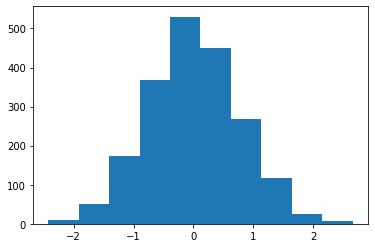

In [73]:
#working on performence the statistical analysis

sanos_boot = np.array(sanos_boot)
no_sanos_boot = np.array(no_sanos_boot)

print(np.mean(sanos_boot[:,2]))
print(np.std(sanos_boot[:,2]))
print(np.mean(no_sanos_boot[:,2]))
print(np.std(no_sanos_boot[:,2]))


plt.hist(sanos_boot[:,2]-no_sanos_boot[:,2])
#plt.hist(no_sanos_boot[:,1])